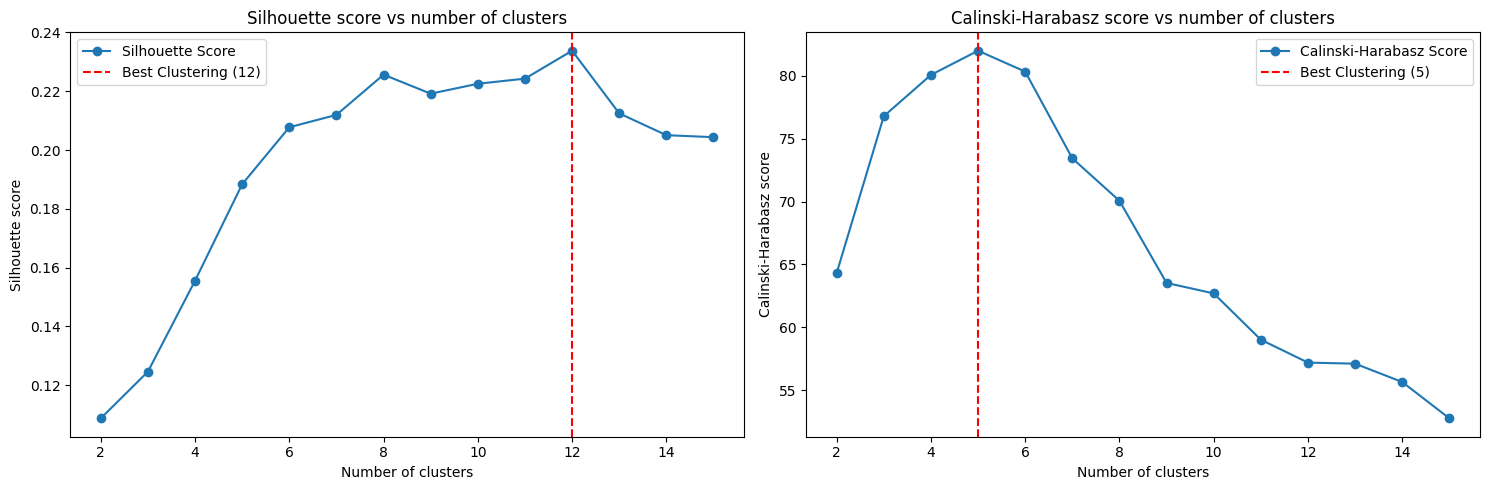

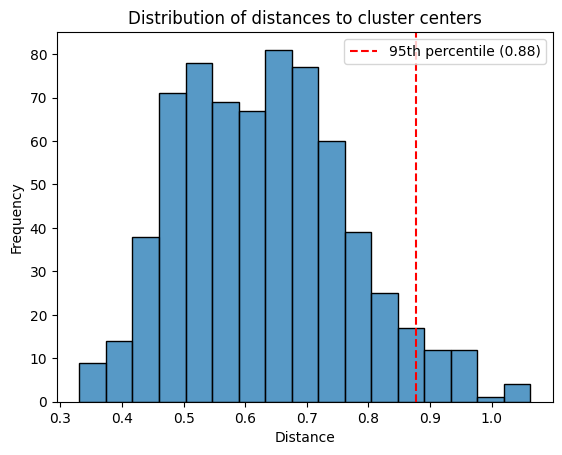

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, pairwise_distances_argmin_min
import os
import shutil
import joblib
import seaborn as sns
import numpy as np


# find_best_number_of_clusters: function that takes a csv file with embeddings and finds the best number of clusters for KMeans clustering.
# params
# results_csv:       the csv file with the embeddings
# min_clusters:      the minimum number of clusters to test
# max_clusters:      the maximum number of clusters to test
# return:            the best number of clusters based on silhouette score and calinski-harabasz score

def find_best_number_of_clusters(results_csv, min_clusters=2, max_clusters=15):
    embeddings_df = pd.read_csv(results_csv)
    embeddings = embeddings_df.T.values
    best_silhouette_score = -1
    best_calinski_score = -1
    best_n_clusters_silhouette = min_clusters
    best_n_clusters_calinski = min_clusters
    silhouette_scores = []
    calinski_scores = []

    if not os.path.exists('Plots'):
        os.makedirs('Plots')
    if not os.path.exists('KMEANS_OUTPUT'):
        os.makedirs('KMEANS_OUTPUT')

    for n_clusters in range(min_clusters, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)
        labels = kmeans.labels_
        silhouette_avg = silhouette_score(embeddings, labels)
        calinski_avg = calinski_harabasz_score(embeddings, labels)
        silhouette_scores.append(silhouette_avg)
        calinski_scores.append(calinski_avg)
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_n_clusters_silhouette = n_clusters

        if calinski_avg > best_calinski_score:
            best_calinski_score = calinski_avg
            best_n_clusters_calinski = n_clusters

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o', label='Silhouette Score')
    plt.axvline(x=best_n_clusters_silhouette, color='r', linestyle='--', label=f'Best Clustering ({best_n_clusters_silhouette})')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.legend()
    plt.title('Silhouette score vs number of clusters')

    plt.subplot(1, 2, 2)
    plt.plot(range(min_clusters, max_clusters + 1), calinski_scores, marker='o', label='Calinski-Harabasz Score')
    plt.axvline(x=best_n_clusters_calinski, color='r', linestyle='--', label=f'Best Clustering ({best_n_clusters_calinski})')
    plt.xlabel('Number of clusters')
    plt.ylabel('Calinski-Harabasz score')
    plt.legend()
    plt.title('Calinski-Harabasz score vs number of clusters')

    plt.tight_layout()
    plt.savefig('Plots/clustering_scores.png')
    plt.show()

    return best_n_clusters_silhouette, best_n_clusters_calinski


# separate_images_by_clusters: function that takes a csv file with embeddings and separates the images into clusters based on KMeans clustering.
# params
# results_csv:          the csv file with the embeddings
# faces_folder:         the folder with the images
# output_base_folder:   the folder to save the clustered images
# n_clusters:           the number of clusters to use
# thresholdperentile:   the percentile to use for the threshold distance
# return:               None
def separate_images_by_clusters(results_csv, faces_folder, output_base_folder, n_clusters=2, thresholdperentile=95):
    embeddings_df = pd.read_csv(results_csv)
    embeddings = embeddings_df.T.values

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)
    joblib.dump(kmeans, os.path.join(output_base_folder, 'kmeans.pkl'))
    labels = kmeans.labels_

    distances = pairwise_distances_argmin_min(embeddings, kmeans.cluster_centers_,metric='euclidean' )[1]
    threshold_distance = np.percentile(distances, thresholdperentile)

    sns.histplot(distances)
    plt.axvline(threshold_distance, color='r', linestyle='--', label=f'95th percentile ({threshold_distance:.2f})')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Distribution of distances to cluster centers')
    plt.savefig('Plots/clusertering_distances.png')
    plt.show()

    for i, file_name in enumerate(embeddings_df.columns):
        src_path = os.path.join(faces_folder, file_name)
        if distances[i] > threshold_distance:
            dst_path = os.path.join(output_base_folder, 'outliers', file_name)
        else:
            dst_path = os.path.join(output_base_folder, f'cluster_{labels[i]}', file_name)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

RESULTS_CSV = 'results\\second_result.csv'
FACES_FOLDER = 'face_folder\\'
OUTPUT_BASE_FOLDER = 'KMEANS_OUTPUT'

best_clusters_silhouette, best_clusters_calinski = find_best_number_of_clusters(RESULTS_CSV)
separate_images_by_clusters(RESULTS_CSV, FACES_FOLDER, OUTPUT_BASE_FOLDER, n_clusters=best_clusters_silhouette, thresholdperentile=95)